# Non centered Multilevel slopes

In [68]:
import math
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
#train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()
train['log_sales_price_std'] = (train[['log_sales_price']] - train[['log_sales_price']].mean()) / train[['log_sales_price']].std()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()
test['log_sales_price_std'] = (test[['log_sales_price']] - train[['log_sales_price']].mean()) / train[['log_sales_price']].std()


In [67]:
len((test[['log_sales_price']] - train[['log_sales_price']].mean()) / train[['log_sales_price']].std())

1459

## Load and simulate fake data

In [22]:
# Import multilevel model
nc_multilevel_slopes = pystan.StanModel(file = '../../models/nc_multilevel_slopes.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_51d86502dd053a1d88b78c378111f184 NOW.


In [23]:
# Set parameters
alpha_sd = 0.01
beta_sd = 0.1
sigma_sd = 1
sigma_nh_sd = 1
Rho_eta =  4

In [24]:
nc_mls_data_check = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           alpha_sd = alpha_sd,
           beta_sd = beta_sd,
           sigma_sd = sigma_sd,
           sigma_nh_sd = sigma_nh_sd,
           Rho_eta =  Rho_eta,
           run_estimation = 0)

fit_nc_mls_check = nc_multilevel_slopes.sampling(data=nc_mls_data_check)
df_nc_mls_check = fit_nc_mls_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Traceplots

In [ ]:
# Inspect model fit
az.plot_trace(fit_nc_mls_check, 
              var_names=["alpha_nh", "beta_nh", "sigma", 'Rho'], 
              compact = True, 
              chain_prop = 'color');

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/density_utils.py:785: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/density_utils.py:785: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/density_utils.py:785: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/density_utils.py:785: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/density_utils.py:785: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/benjaminwee/opt

OverflowError: cannot convert float infinity to integer

## Prior predcitive checks

<AxesSubplot:xlabel='log_sales_price / y_hat'>

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


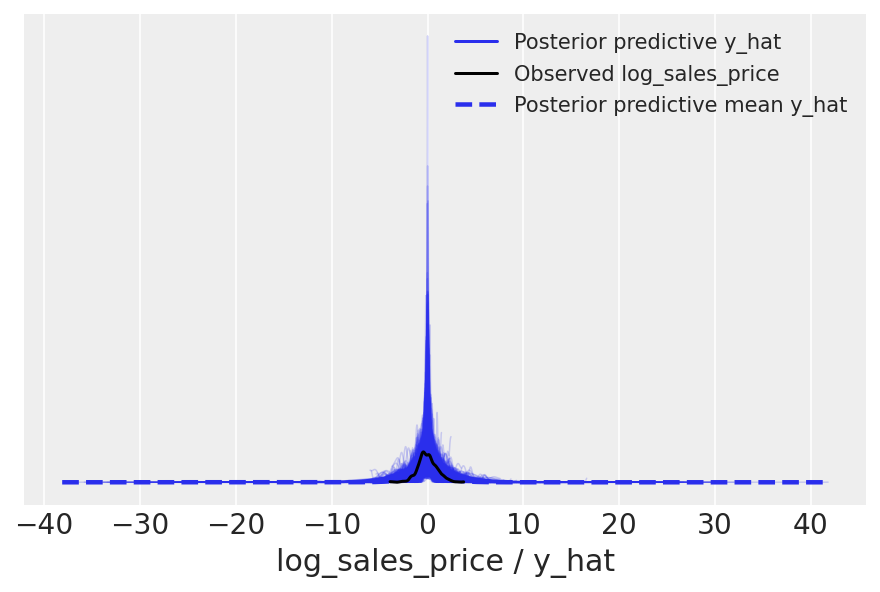

In [25]:
nc_mls_check_az = az.from_pystan(
    posterior=fit_nc_mls_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

az.plot_ppc(data = nc_mls_check_az, kind = 'kde', data_pairs = {'log_sales_price' : 'y_hat'})

#az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

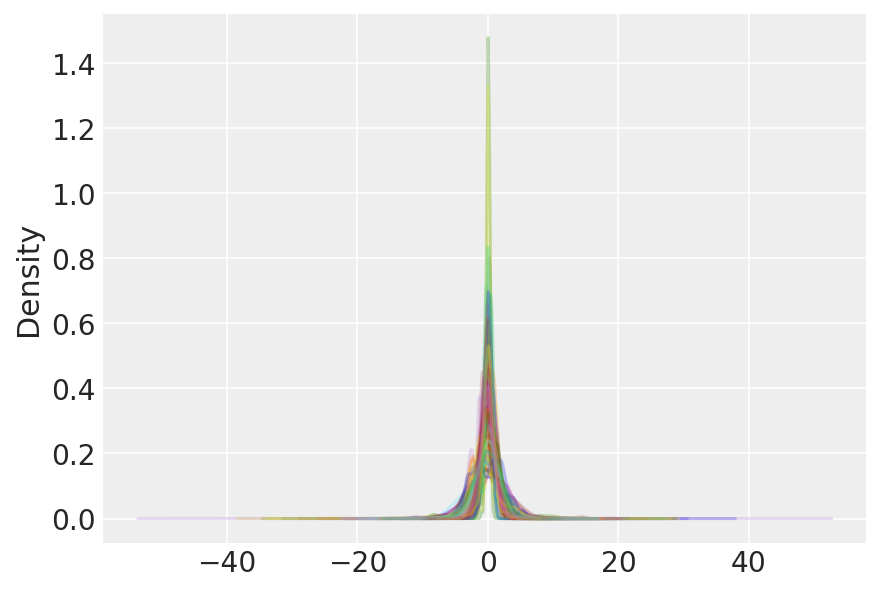

In [27]:
fig, axes = plt.subplots(1,1)

df_nc_mls_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                        ax=axes);

#train['log_sales_price_std'].plot.kde(legend = False, 
#                            alpha = 1,
#                            ax = axes);

## Fit model on fake data and recapture known parameters

In [28]:
# Select random draw from joint prior distribution and implied dgp of y
random_draw = 10
y_sim = df_nc_mls_check.filter(regex = 'y_hat').iloc[random_draw, :]
true_parameters = df_nc_mls_check.filter(regex = 'za_nh|zb_nh|sigma|Rho').iloc[random_draw, :]

_nc_mls_data_check = dict(N = len(train),
              log_sales_price = y_sim,
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = alpha_sd,
              beta_sd = beta_sd,
              sigma_sd = sigma_sd,
              sigma_nh_sd = sigma_nh_sd,
              Rho_eta =  Rho_eta,
              run_estimation = 1)

_fit_nc_mls_check = nc_multilevel_slopes.sampling(data=_nc_mls_data_check)
_nc_mls_df_check = _fit_nc_mls_check.to_dataframe()


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


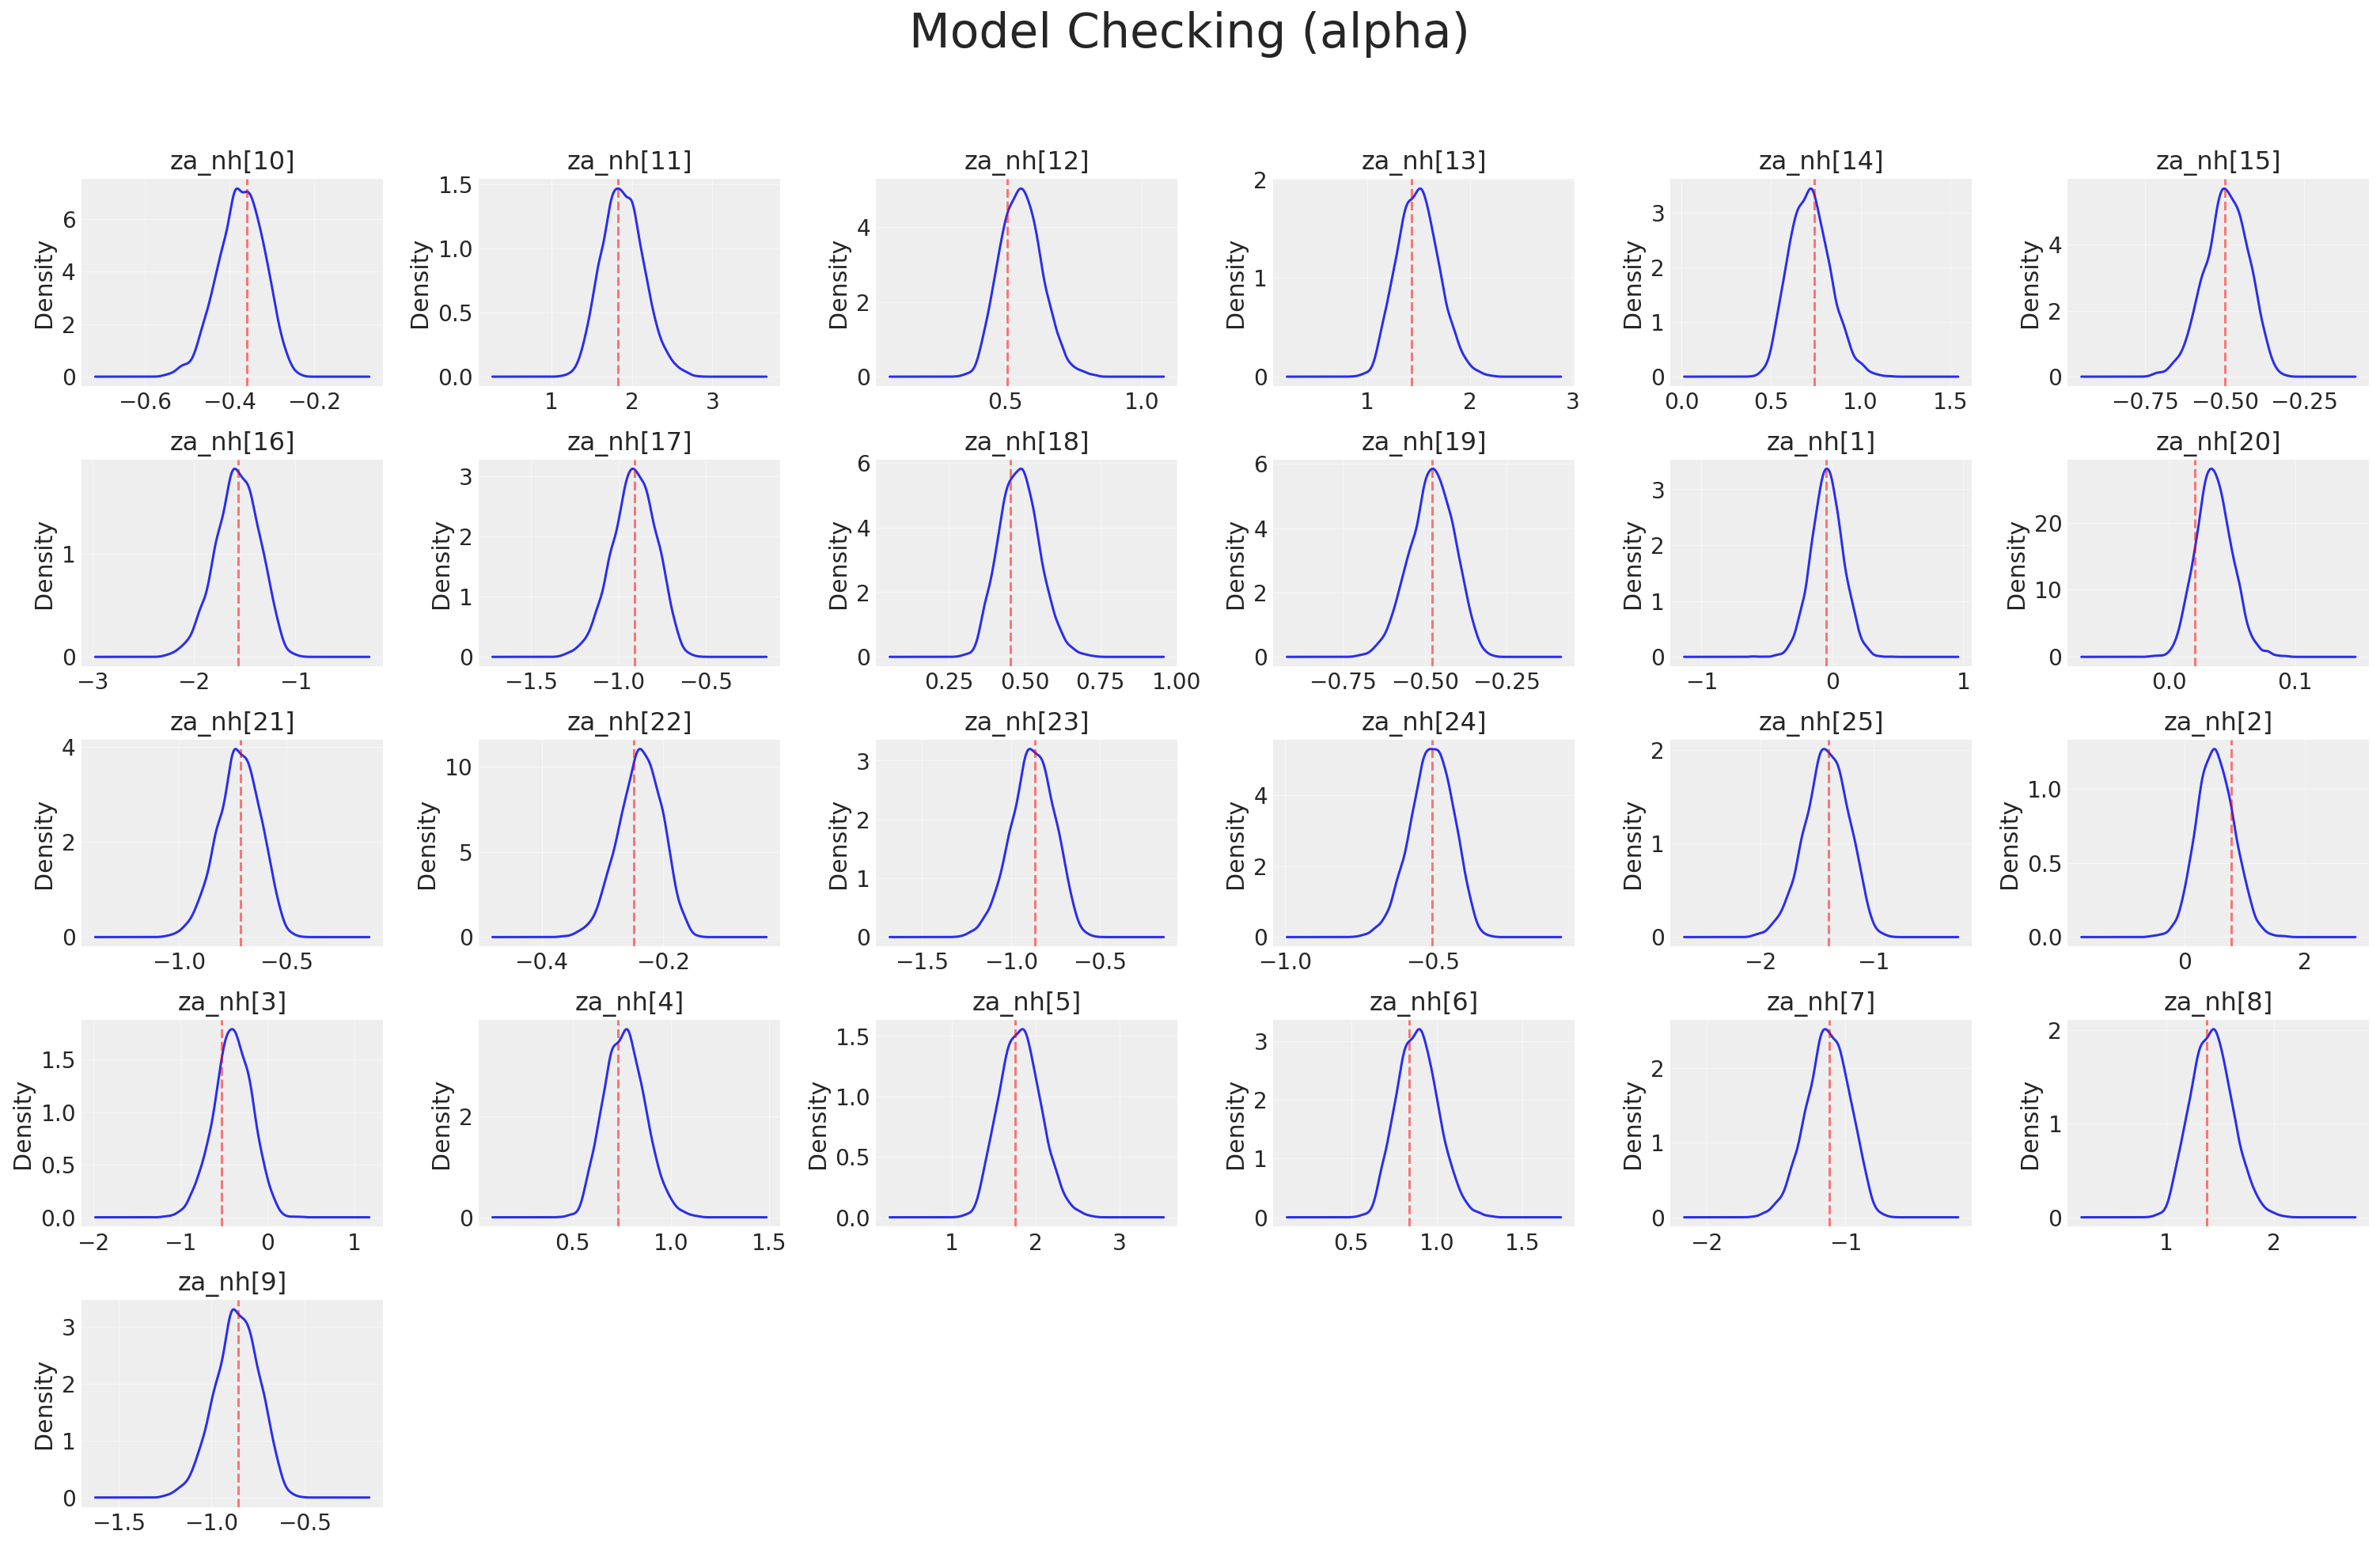

In [29]:
fake_fit = _nc_mls_df_check.filter(regex = 'za_nh')
parameter_df = pd.melt(fake_fit)

# Plot all parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking (alpha)', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=
                       False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


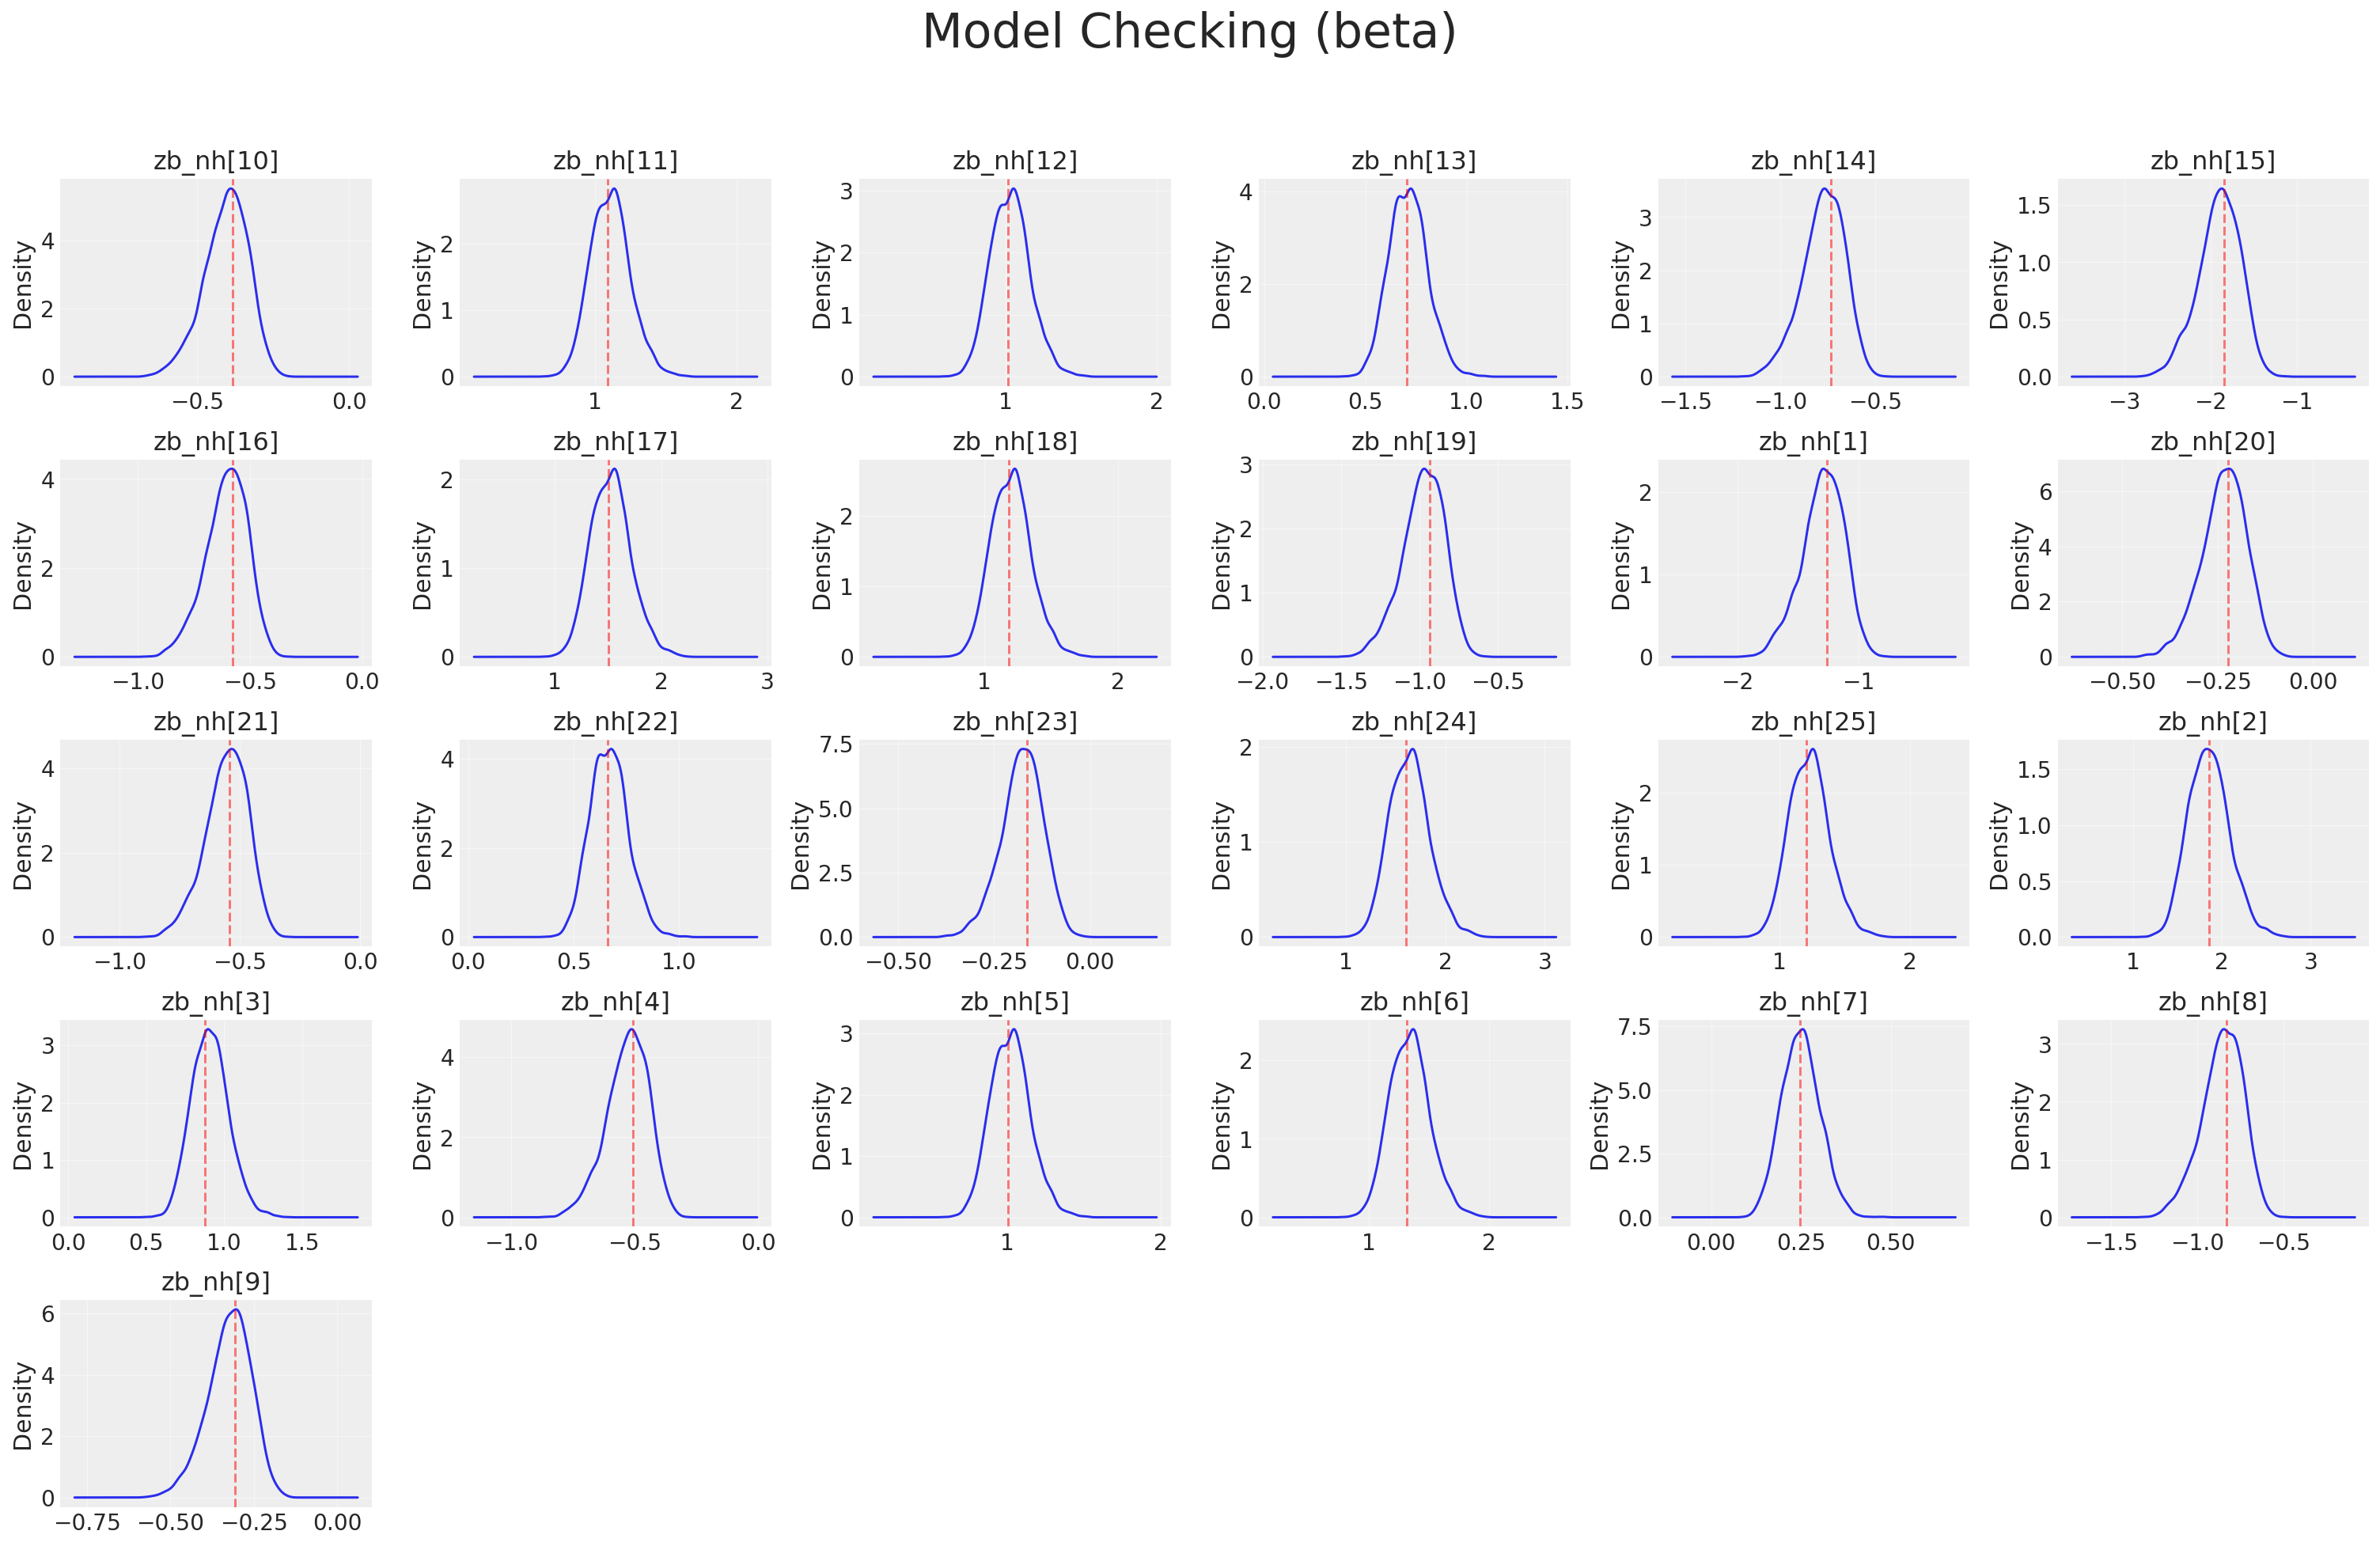

In [30]:
fake_fit = _nc_mls_df_check.filter(regex = 'zb_nh')
parameter_df = pd.melt(fake_fit)

# Plot all parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking (beta)', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


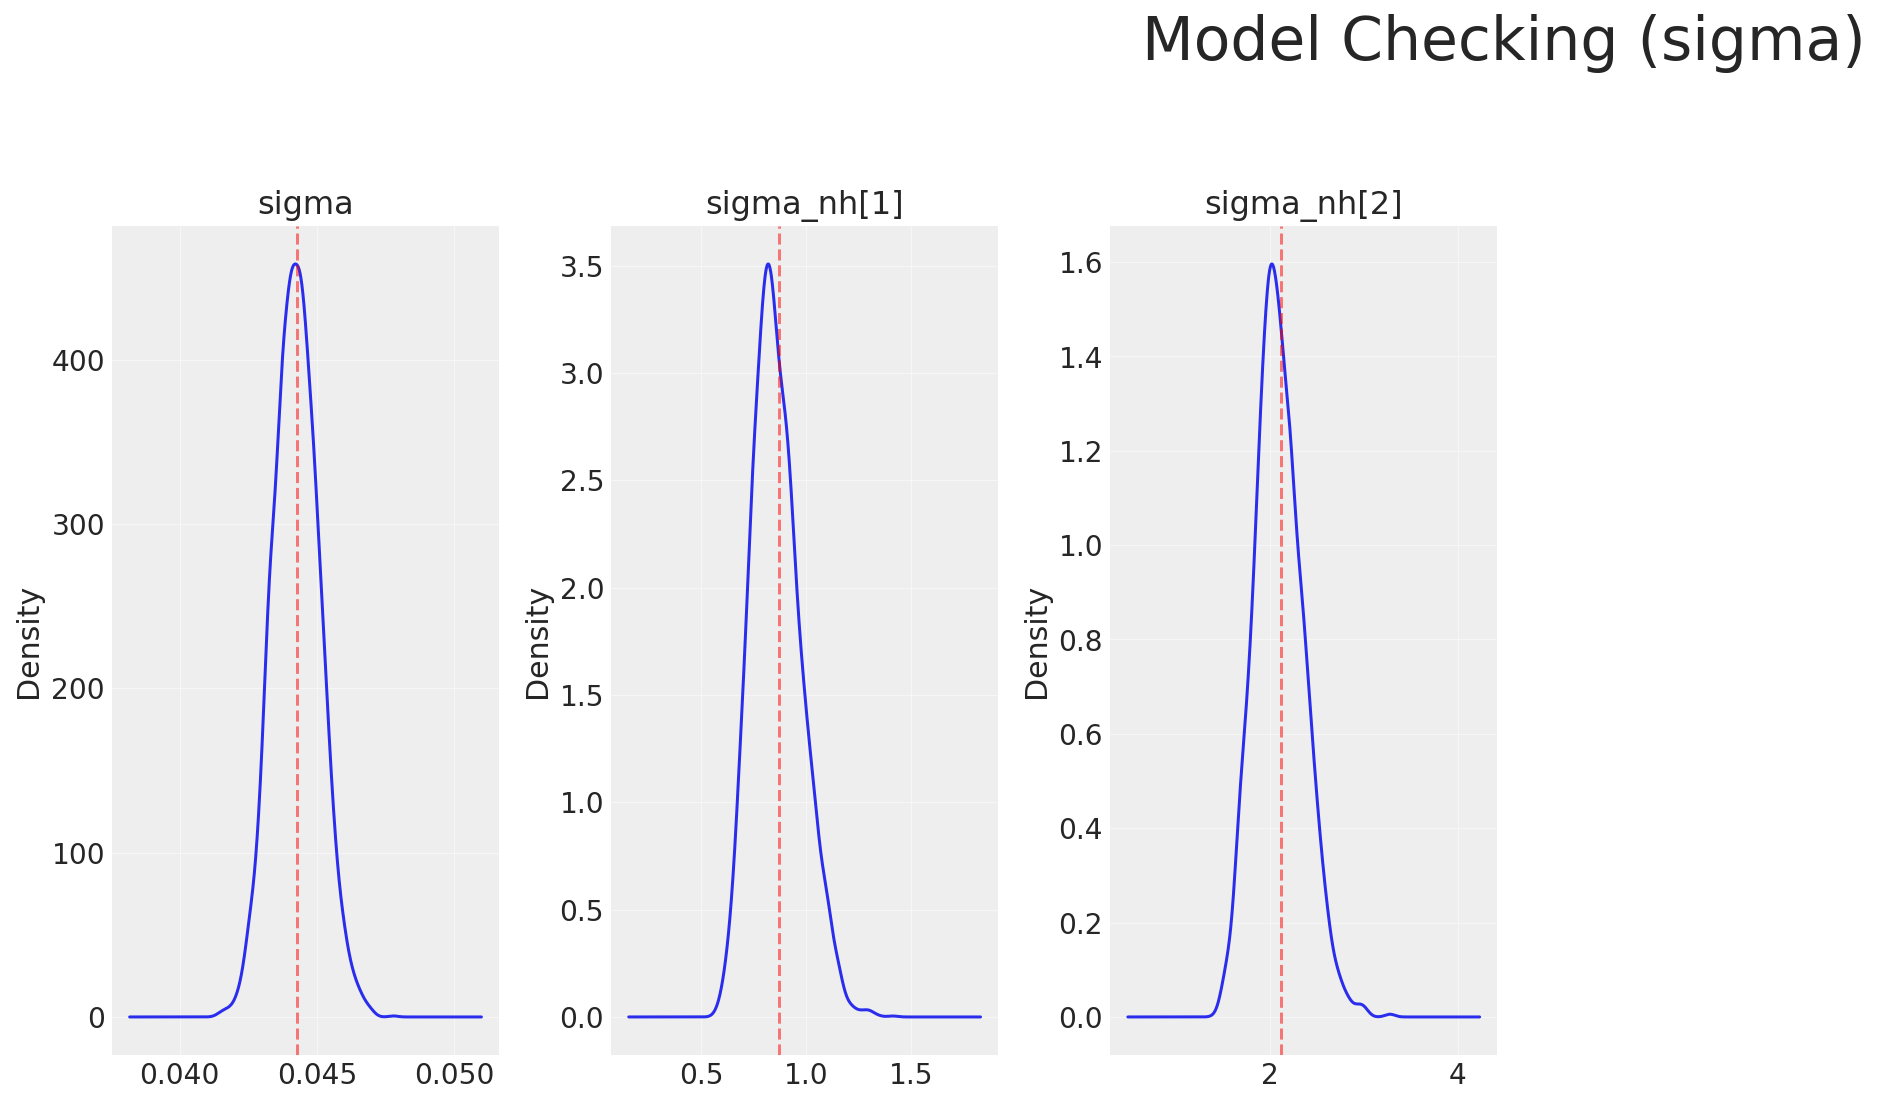

In [31]:
fake_fit = _nc_mls_df_check.filter(regex = 'sigma')
parameter_df = pd.melt(fake_fit)

# Plot all parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking (sigma)', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

## Fit model on real data

In [87]:
nc_mls_data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           alpha_sd = alpha_sd,
           beta_sd = beta_sd,
           sigma_sd = sigma_sd,
           sigma_nh_sd = sigma_nh_sd,
           Rho_eta =  Rho_eta,
           run_estimation = 1)

# Fit model
fit_nc_mls = nc_multilevel_slopes.sampling(data=nc_mls_data)

nc_mls_az = az.from_pystan(
    posterior=fit_nc_mls,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_nc_mls_df = fit_nc_mls.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [90]:
len(np.exp((fit_nc_mls_df.filter(regex = 'y_hat').mean(axis=0))))

1460

## Posterior predictive check

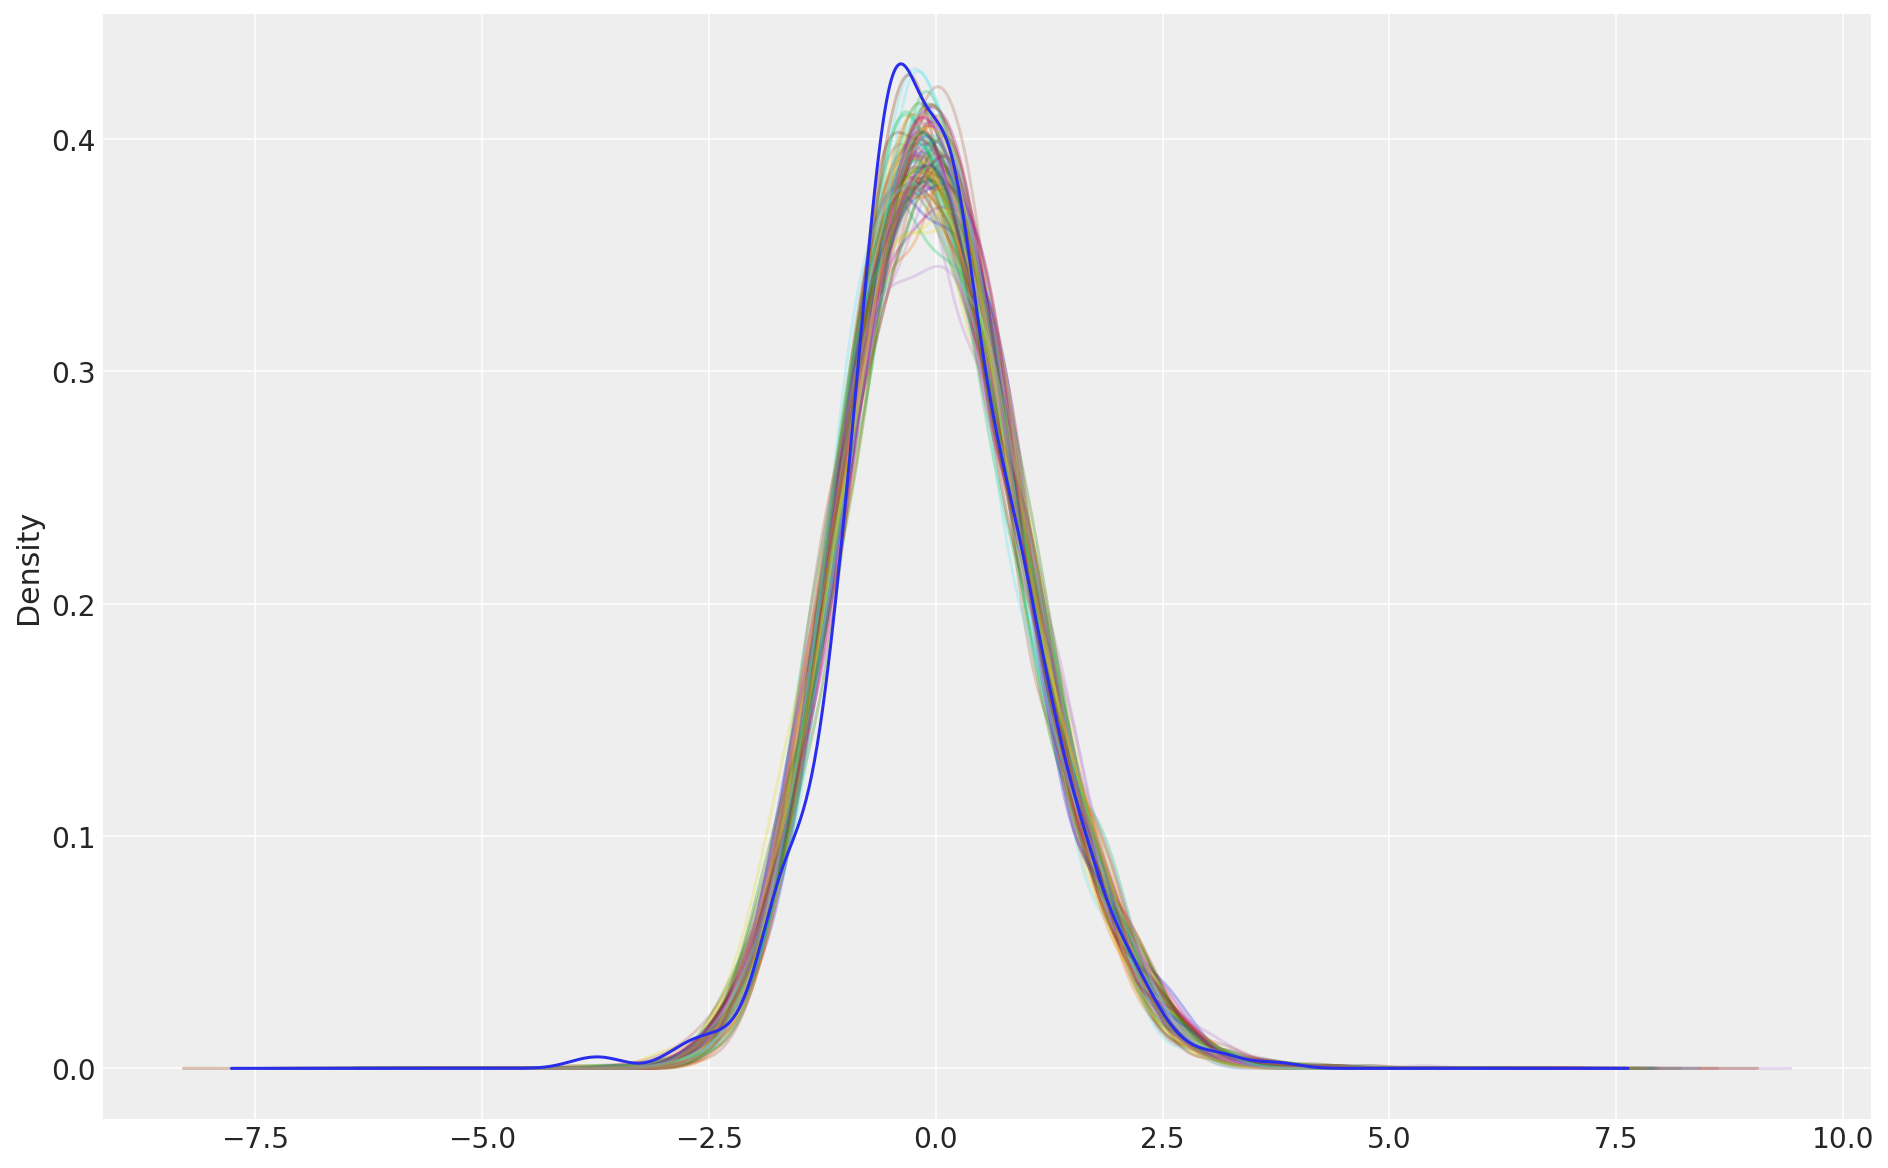

In [33]:
fig, axes = plt.subplots(1,1, figsize = (13,8))

fit_nc_mls_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

In [70]:
az.loo(nc_mls_az, pointwise = True, scale = 'log')

Computed from 4000 by 1460 log-likelihood matrix

         Estimate       SE
elpd_loo -1317.38    38.67
p_loo       44.88        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1459   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<AxesSubplot:xlabel='log_sales_price / y_hat'>

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


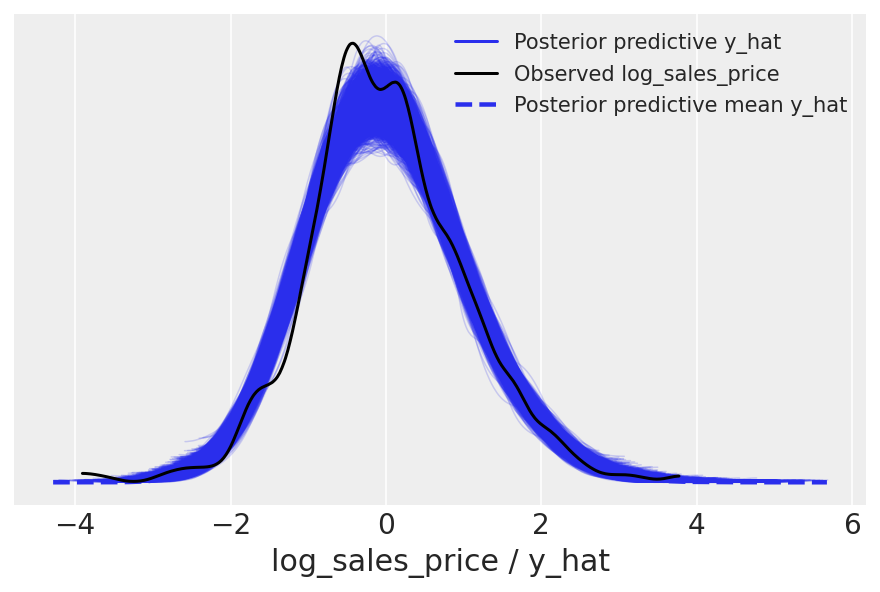

In [35]:
az.plot_ppc(data = nc_mls_az, kind = 'kde', data_pairs = {'log_sales_price' : 'y_hat'})

(-0.1, 1.5)

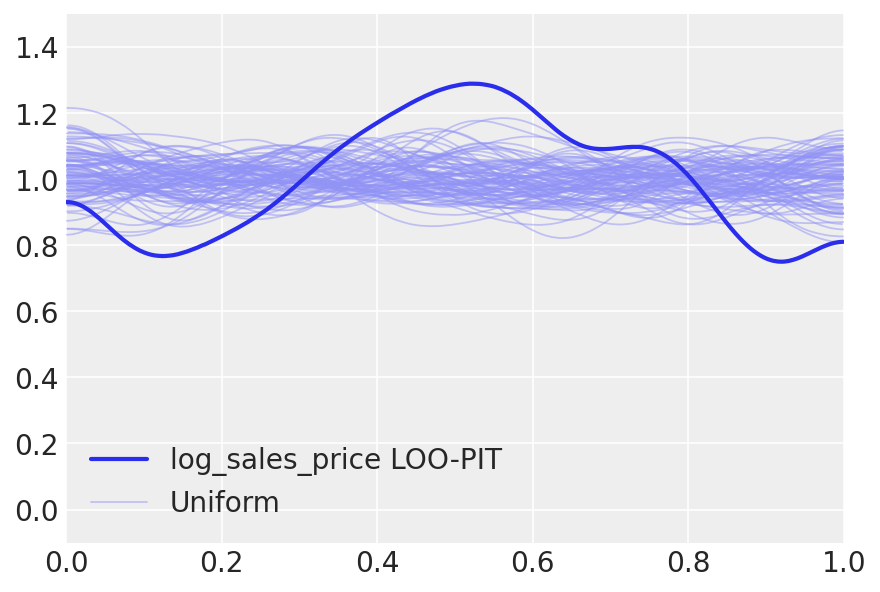

In [71]:
az.plot_loo_pit(idata=nc_mls_az, y = 'log_sales_price', y_hat = 'y_hat')
plt.ylim(-0.1,1.5)

## Trace plots

In [ ]:
az.plot_trace(fit_nc_mls, var_names=["alpha_nh", "beta_nh", "sigma", 'Rho'], compact = True);

## Posterior predictive checks on raw scale

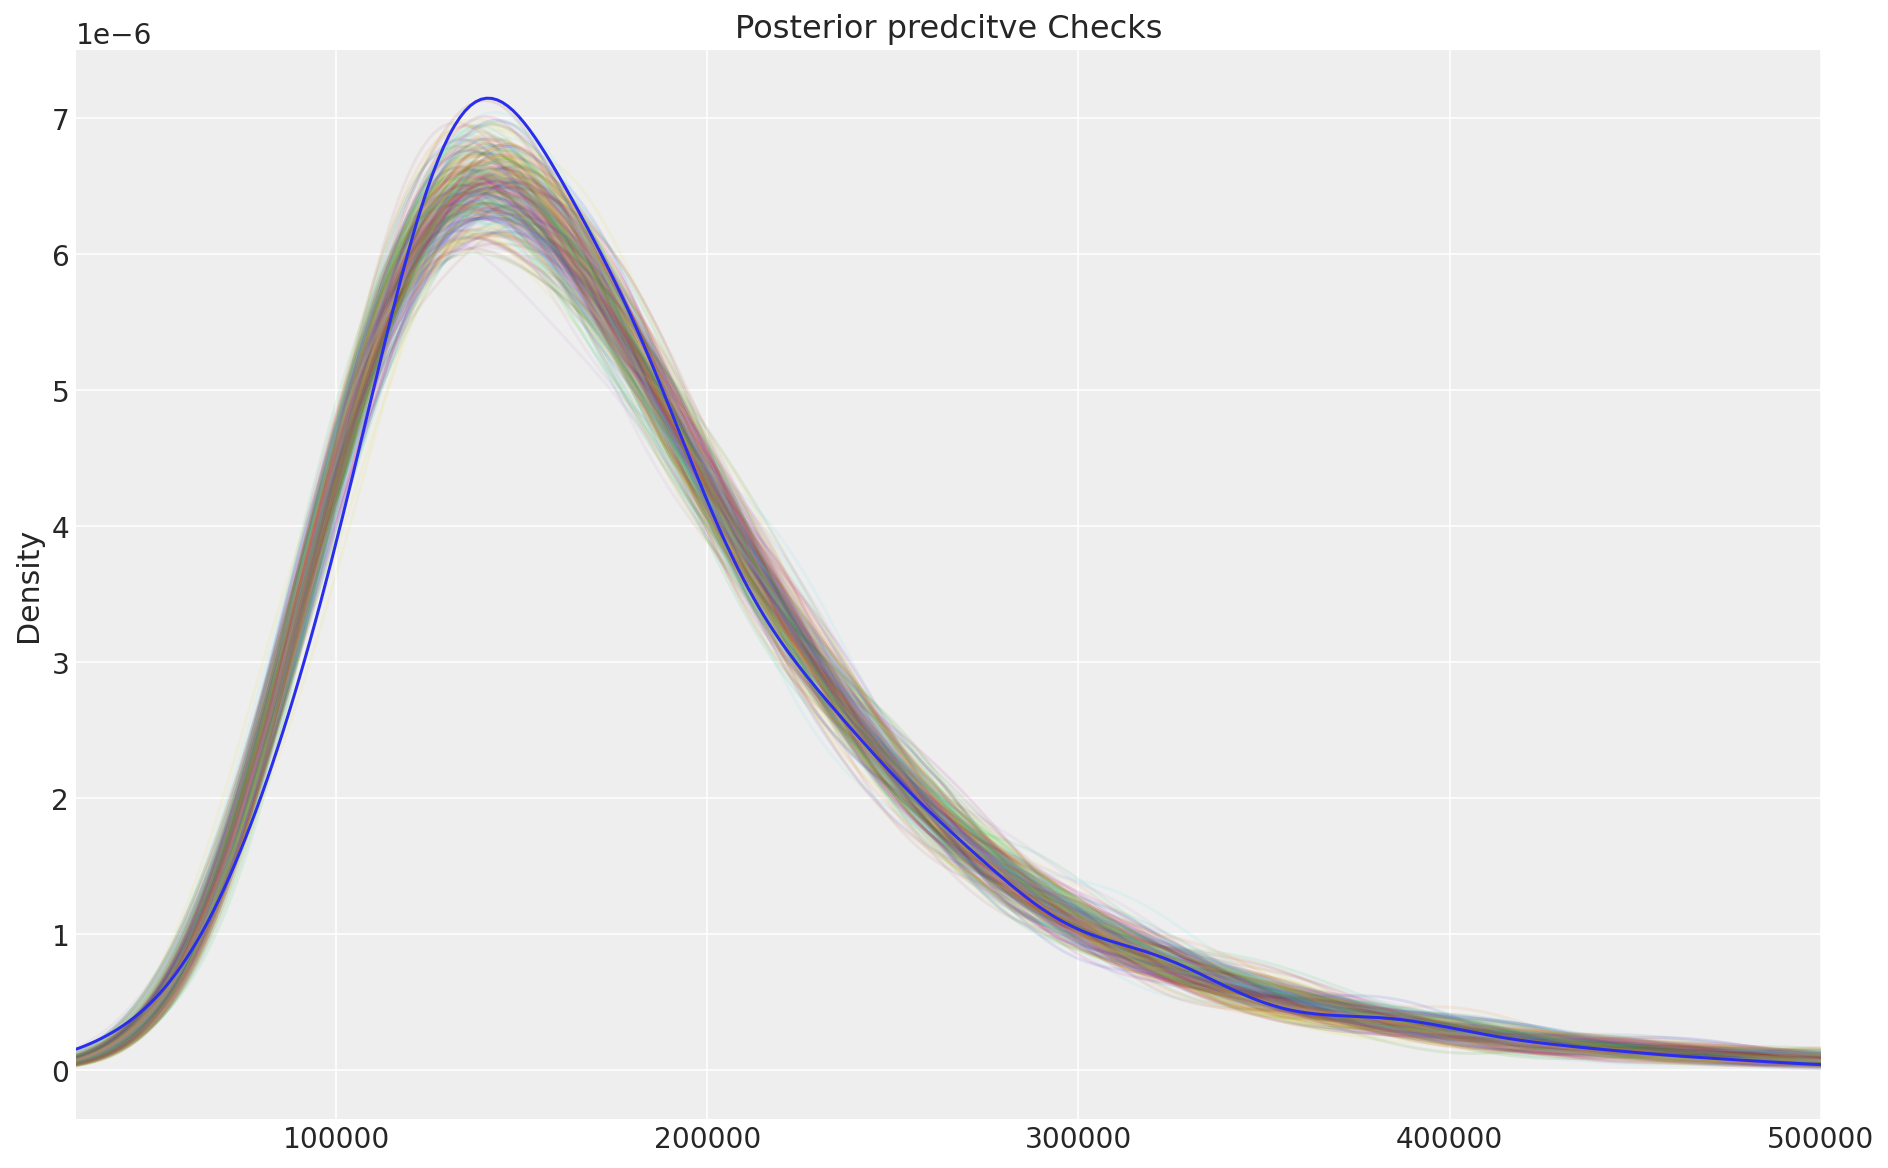

In [38]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))
np.exp(fit_nc_mls_df.filter(regex = 'y_hat')*train['log_sales_price'].std()+train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predcitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);
train['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

In [94]:
predictions = pd.DataFrame(np.exp((fit_nc_mls_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].std())+train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

nc_multilevel_slope_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

nc_multilevel_slope_csv.to_csv('../../data/submissions/nc_multilevel_slope.csv', index = False)

In [96]:
%%sh
cd ../../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f nc_multilevel_slope.csv -m "Partial pooling (multilevel slopes) with non centered parameterisation"


Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:07<00:00, 4.58kB/s]
